In [20]:
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
warnings.filterwarnings("ignore")

# LAB 2

### Retall de sub-imatges

In [21]:
def llegir_retallar(nombre_archivo):
    img = cv2.imread('imgs/' + str(nombre_archivo) + '.jpg', cv2.COLOR_BGR2GRAY)
    img1 = img[:img.shape[0]//3, :]
    img2 = img[img.shape[0]//3:(img.shape[0]//3)*2, :]
    img3 = img[(img.shape[0]//3)*2:, :]
    #plt.imshow(img1, cmap='gray')
    #plt.imshow(img2, cmap='gray')
    #plt.imshow(img3, cmap='gray')
    return [img1, img2, img3]





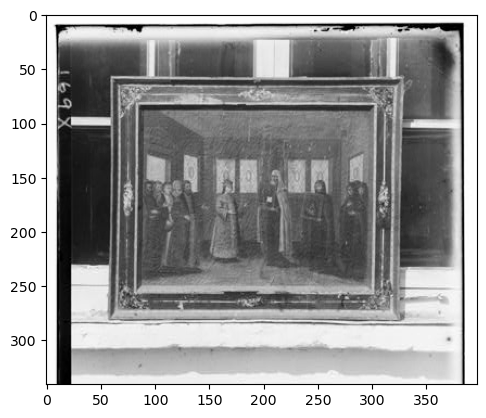

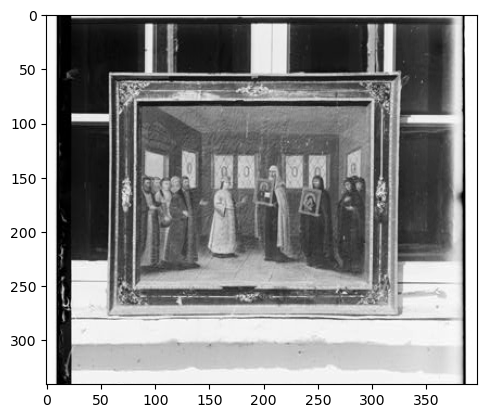

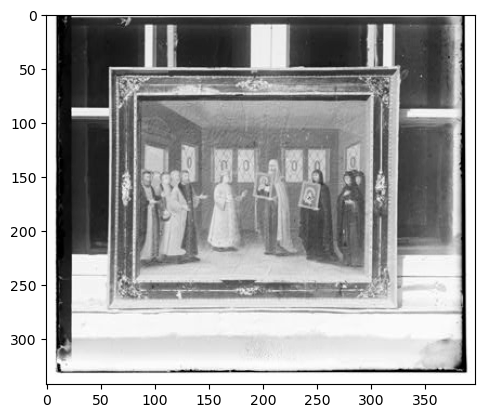

In [22]:
archivos = os.listdir('imgs')
archivos = [a.removesuffix('.jpg') for a in archivos if a.endswith('.jpg')]


def llegir_imatges(archivos):
    images = {}
    for i in archivos:
        img = llegir_retallar(i)
        images[i] = img
    return images
images = llegir_imatges(archivos)


plt.imshow(images[archivos[0]][0], cmap='gray')
plt.show()
plt.imshow(images[archivos[0]][1], cmap='gray')
plt.show()
plt.imshow(images[archivos[0]][2], cmap='gray')
plt.show()
    


In [23]:
def recortar_marcos(img):
    gauss = cv2.GaussianBlur(img, (5,5), 0)
    _, binarizada = cv2.threshold(gauss, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    contornos, _ = cv2.findContours(binarizada, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    mayor_contorno = max(contornos, key=cv2.contourArea)
    
    x, y, w, h = cv2.boundingRect(mayor_contorno)
    
    imagen_recortada = img[y:y+h, x:x+w]
    
    return imagen_recortada

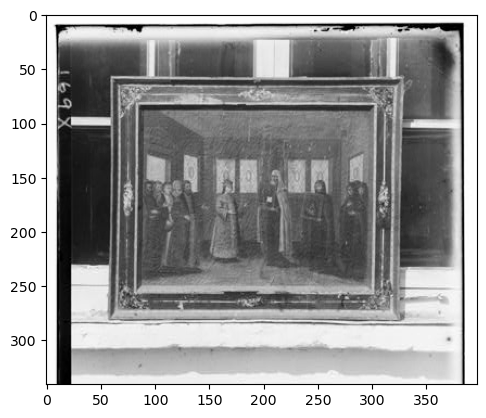

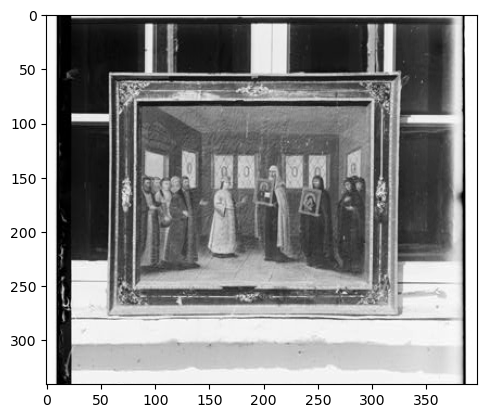

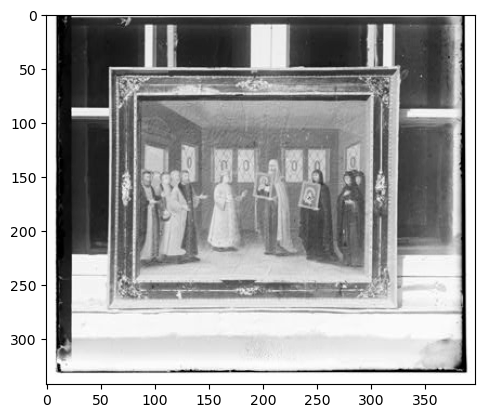

In [24]:

imagen1  = np.array(images[archivos[0]][0])
imagen2  = np.array(images[archivos[0]][1])
imagen3  = np.array(images[archivos[0]][2])
plt.imshow(imagen1, cmap='gray')
plt.show()
plt.imshow(imagen2, cmap='gray')
plt.show()
plt.imshow(imagen3, cmap='gray')
plt.show()

In [25]:
print(imagen1.shape, imagen2.shape, imagen3.shape)

(341, 397) (341, 397) (342, 397)


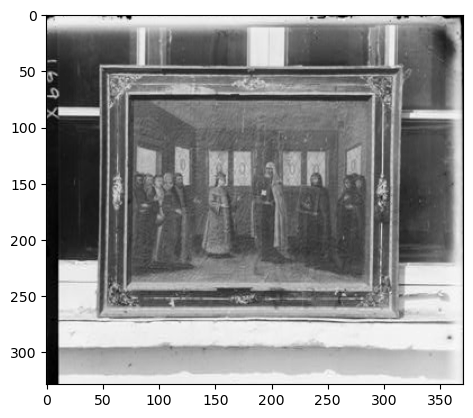

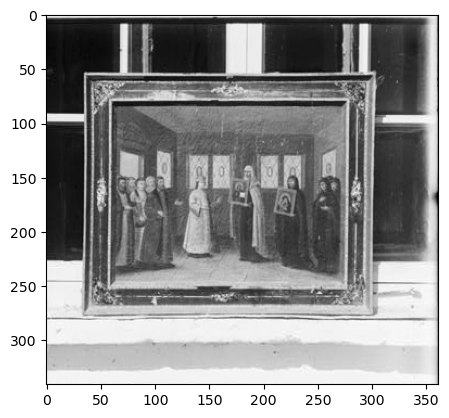

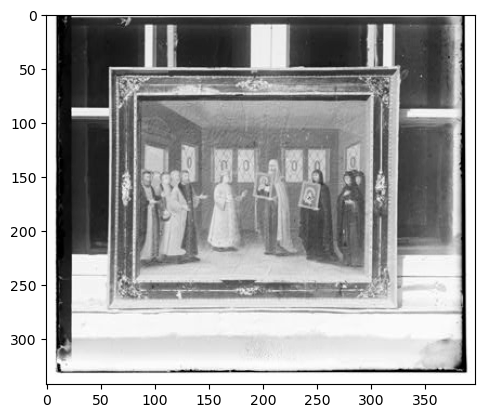

In [26]:
imagen1 = recortar_marcos(imagen1)
imagen2 = recortar_marcos(imagen2)
imagen3 = recortar_marcos(imagen3)
plt.imshow(imagen1, cmap='gray')
plt.show()
plt.imshow(imagen2, cmap='gray')
plt.show()
plt.imshow(imagen3, cmap='gray')
plt.show()

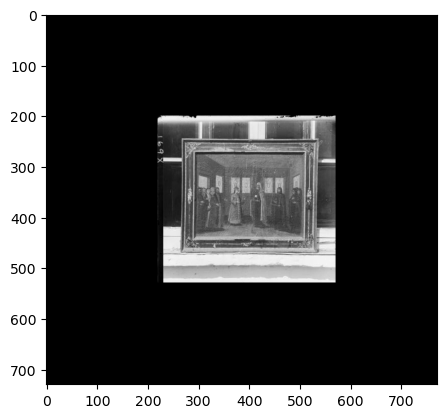

In [27]:
imagen1_desplazada = np.roll(imagen1, 20, axis=1)
imagen1_desplazada[:, :20] = 0
imagen1_desplazada = cv2.copyMakeBorder(imagen1_desplazada, 200, 200, 200, 200, cv2.BORDER_CONSTANT)

plt.imshow(imagen1_desplazada, cmap='gray')
plt.show()

(329, 371) (401, 401)


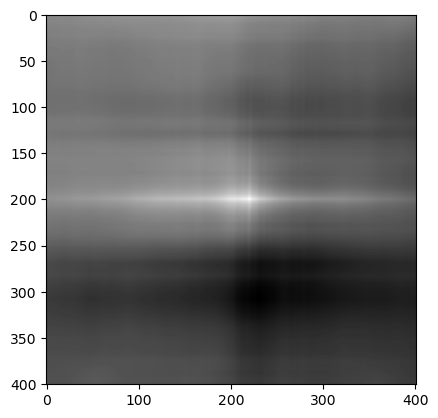

In [28]:
resultado_correlacion = cv2.matchTemplate(imagen1_desplazada, imagen1, cv2.TM_CCOEFF_NORMED)
print(imagen1.shape, resultado_correlacion.shape)
plt.imshow(resultado_correlacion, cmap='gray')
plt.show()


In [29]:
min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(resultado_correlacion)
max_val, max_loc


(0.8155032396316528, (220, 200))

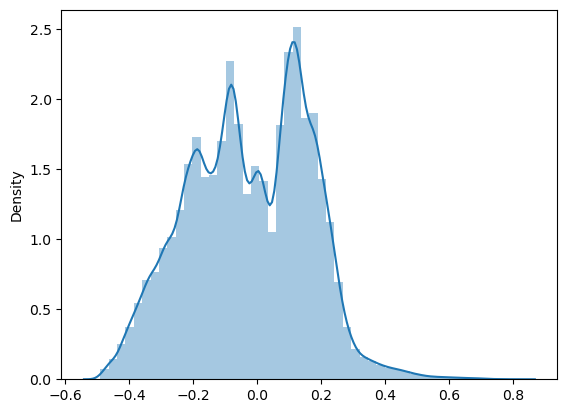

In [30]:
sns.distplot(resultado_correlacion.flatten())
plt.show()

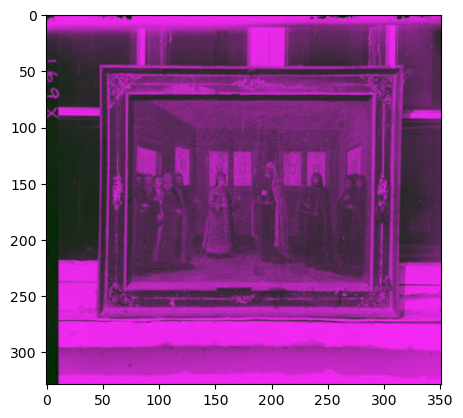

In [31]:
res = np.copy(imagen1_desplazada)
res = np.reshape(res, (res.shape[0], res.shape[1], 1))
res = np.concatenate([res, res, res], axis=2)

h, w = imagen1.shape[:2]
x = max_loc[0]
y = max_loc[1]
    
res[y:y+h, x:x+w,1] = 40

plt.imshow(res[200:-(200), 200 + 20:-(200), :])

### Funcion para alinear imagenes

In [32]:
CORRELACION_BASADA_CONVOlUCÍON = 0
CORRELACION_BASADA_CONVOlUCÍON_NORMALIZADA = 1
CORRELACION_BASADA_FOURIER = 2
CORRELACION_BASADA_ESPAI_FOURIER = 3

In [129]:
def alinear_imagenes(imagen1, imagen2, imagen3, metodo=CORRELACION_BASADA_CONVOlUCÍON_NORMALIZADA):
        
    altura_img, ancho_img = imagen1.shape[:2]
    altura_plantilla, ancho_plantilla = imagen2.shape[:2]
    print(altura_img, ancho_img, altura_plantilla, ancho_plantilla)
    pad_alto = altura_plantilla - 1
    pad_ancho = ancho_plantilla - 1

    imagen_padded = cv2.copyMakeBorder(imagen1, pad_alto, pad_alto, pad_ancho, pad_ancho, cv2.BORDER_CONSTANT)

    res = np.copy(imagen_padded)
    res = np.reshape(res, (res.shape[0], res.shape[1], 1))
    res = np.concatenate([res, res, res], axis=2)
    
    #pfimera correlacion, imagen1 con imagen2
    if metodo == CORRELACION_BASADA_CONVOlUCÍON:
        resultado_correlacion = cv2.matchTemplate(imagen_padded, imagen2, cv2.TM_CCORR)
    elif metodo == CORRELACION_BASADA_CONVOlUCÍON_NORMALIZADA:
        resultado_correlacion = cv2.matchTemplate(imagen_padded, imagen2, cv2.TM_CCORR_NORMED)
    elif metodo == CORRELACION_BASADA_FOURIER:
        max_width = max(imagen1.shape[0], imagen2.shape[0], imagen3.shape[0])
        max_height = max(imagen1.shape[1], imagen2.shape[1], imagen3.shape[1])
        
        imagen1 = cv2.resize(imagen1, (max_width, max_height))
        imagen2 = cv2.resize(imagen2, (max_width, max_height))
        imagen3 = cv2.resize(imagen3, (max_width, max_height))
        if max_height >= max_width:
            pad_alto_top = (max_height - max_width)//2
            pad_alto_bottom = (max_height - max_width) - pad_alto_top
            imagen1 = cv2.copyMakeBorder(imagen1, 0, 0, pad_alto_top, pad_alto_bottom, cv2.BORDER_CONSTANT, value=0)
            imagen2 = cv2.copyMakeBorder(imagen2, 0, 0, pad_alto_top, pad_alto_bottom, cv2.BORDER_CONSTANT, value=0)
            imagen3 = cv2.copyMakeBorder(imagen3, 0, 0, pad_alto_top, pad_alto_bottom, cv2.BORDER_CONSTANT, value=0)
        else:
            pad_ancho_left = (max_width - max_height)//2
            pad_ancho_right = (max_width - max_height) - pad_ancho_left
            imagen1 = cv2.copyMakeBorder(imagen1, pad_ancho_left, pad_ancho_right, 0, 0, cv2.BORDER_CONSTANT, value=0)
            imagen2 = cv2.copyMakeBorder(imagen2, pad_ancho_left, pad_ancho_right, 0, 0, cv2.BORDER_CONSTANT, value=0)
            imagen3 = cv2.copyMakeBorder(imagen3, pad_ancho_left, pad_ancho_right, 0, 0, cv2.BORDER_CONSTANT, value=0)
        
        
        print('Shape imagen1: '+str(imagen1.shape))
        print('Shape imagen2: '+str(imagen2.shape))
        imagen_fft = np.fft.fft2(imagen1)
        plantilla_fft = np.fft.fft2(imagen2)
        plantilla_fft = np.transpose(plantilla_fft)

        correlacion_fft_1 = np.fft.ifft2(imagen_fft * np.conj(plantilla_fft))
        plt.imshow(np.abs(correlacion_fft_1), cmap='gray')
        plt.title('Correlación')
        plt.colorbar()
        plt.show()

        #Segunda correlacion, imagen1 con imagen3
        
        imagen3_copy = cv2.resize(imagen3, (imagen_padded.shape[0], imagen_padded.shape[1]))
        imagen_fft = np.fft.fft2(imagen_padded)
        plantilla_fft = np.fft.fft2(imagen3_copy)
        plantilla_fft = np.transpose(plantilla_fft)

        correlacion_fft_2 = np.fft.ifft2(imagen_fft * np.conj(plantilla_fft))

        plt.imshow(np.abs(correlacion_fft_2), cmap='gray')
        plt.title('Correlación_2')
        plt.colorbar()
        plt.show()
        #Alinear imagenes
        # Encontrar la posición del pico de correlación máxima
        h_1, w_1 = imagen2.shape[:2]
        max_corr_idx_1 = np.unravel_index(np.argmax(correlacion_fft_1), correlacion_fft_1.shape)
        y_1, x_1 = max_corr_idx_1
        h_2, w_2 = imagen3.shape[:2]
        max_corr_idx_2 = np.unravel_index(np.argmax(correlacion_fft_2), correlacion_fft_2.shape)
        y_2, x_2 = max_corr_idx_2
    
        # Calcular el desplazamiento
        altura_imagen_1, ancho_imagen_1 = imagen2.shape[:2]
        desplazamiento_y_1 = y_1 - altura_imagen_1
        desplazamiento_x_1 = x_1 - ancho_imagen_1

        altura_imagen_2, ancho_imagen_2 = imagen3.shape[:2]
        desplazamiento_y_2 = y_2 - altura_imagen_2
        desplazamiento_x_2 = x_2 - ancho_imagen_2
        
        
        # Aplicar el desplazamiento a la imagen
        imagen2_alineada = np.roll(imagen2, (desplazamiento_y_1, desplazamiento_x_1), axis=(0, 1))
        imagen3_alineada = np.roll(imagen3, (desplazamiento_y_2, desplazamiento_x_2), axis=(0, 1))
        print('Shape imagen2_ali: '+str(imagen2_alineada.shape))
        print('Shape imagen3_ali: '+str(imagen3_alineada.shape))
        plt.imshow(imagen2_alineada, cmap='gray')
        plt.title('Correlación')
        plt.colorbar()
        plt.show()

        plt.imshow(imagen3_alineada, cmap='gray')
        plt.title('Correlación')
        plt.colorbar()
        plt.show()
        res = np.copy(imagen1)
        res = np.reshape(res, (res.shape[0], res.shape[1], 1))
        res = np.concatenate([res, res, res], axis=2)
        res[:, :, 1] = imagen2_alineada
        res[:, :, 2] = imagen3_alineada
        return res
        
        
    _, max_val, _, max_loc = cv2.minMaxLoc(resultado_correlacion)
    
    print(f'Máximo valor de correlación: {max_val} posiocion: {max_loc}')
    
    h, w = imagen2.shape[:2]
    x = max_loc[0]
    y = max_loc[1]
    
    res[y:y+h, x:x+w,1] = imagen2
    resultado_correlacion = cv2.matchTemplate(imagen_padded, imagen3, metodo)

    _, max_val, _, max_loc = cv2.minMaxLoc(resultado_correlacion)
    
    print(f'Máximo valor de correlación: {max_val} posiocion: {max_loc}')
    
    h, w = imagen3.shape[:2]
    x = max_loc[0]
    y = max_loc[1]
    
    res[y:y+h, x:x+w,2] = imagen3

    return res[pad_alto:-(pad_alto), pad_ancho:-(pad_ancho), :]

In [60]:
imagen1.shape, imagen2.shape, imagen3.shape

((329, 371), (341, 361), (342, 397))

#### Correlació basada en convloució en l'espai

329 371 341 361
Máximo valor de correlación: 2515391488.0 posiocion: (372, 332)


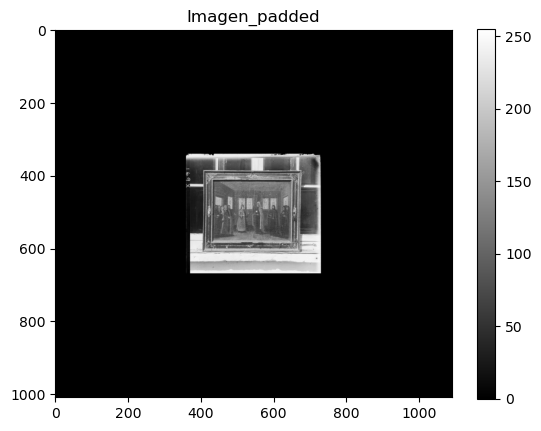

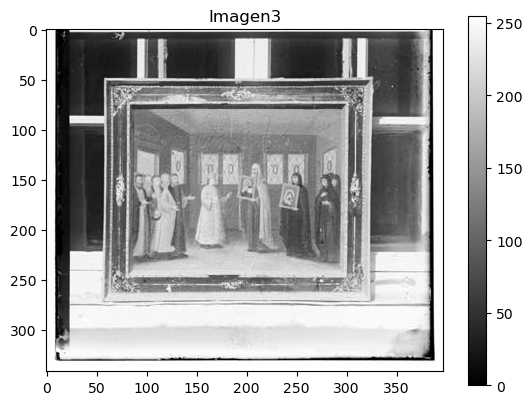

Máximo valor de correlación: 4172947968.0 posiocion: (362, 612)


In [69]:
res = alinear_imagenes(imagen1, imagen2, imagen3, metodo=CORRELACION_BASADA_CONVOlUCÍON)

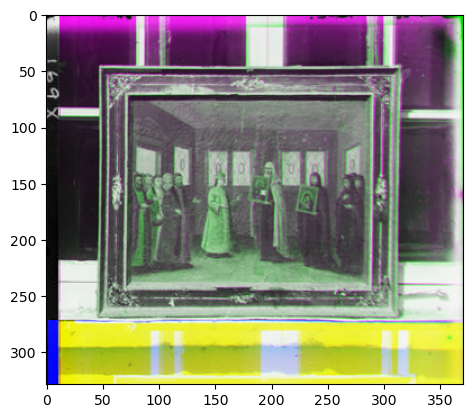

In [62]:
plt.imshow(res)
plt.show()

#### CORRELACIÓ BASADA ESPAI FOURIER

329 371 341 361
Shape imagen1: (397, 397)
Shape imagen2: (397, 397)


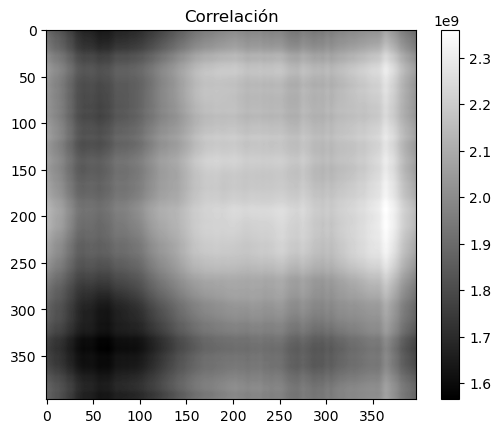

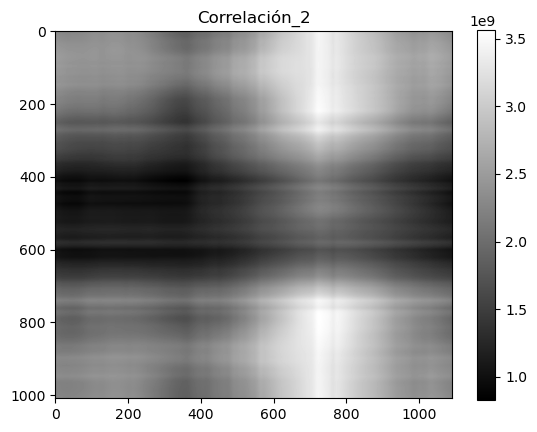

Shape imagen2_ali: (397, 397)
Shape imagen3_ali: (397, 397)


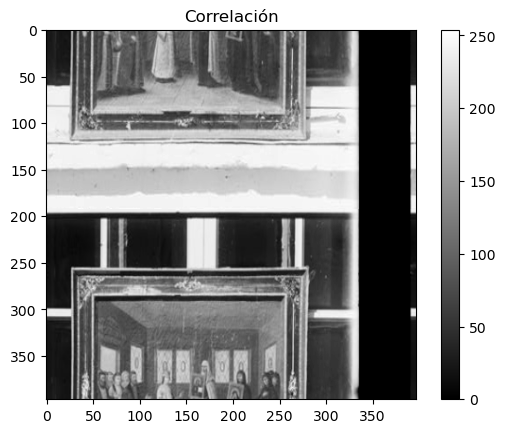

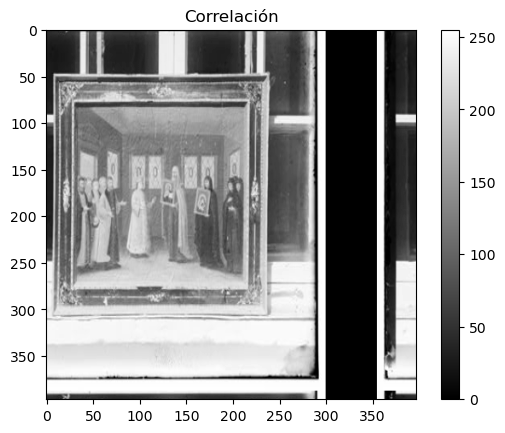

In [130]:
res = alinear_imagenes(imagen1, imagen2, imagen3, metodo=CORRELACION_BASADA_FOURIER)


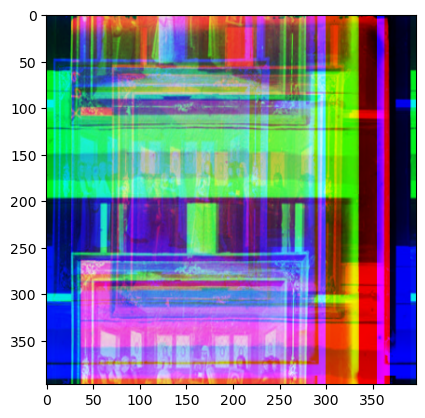

In [131]:
plt.imshow(res)
plt.show()